In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [9]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Fraud.csv")
print(df.shape)
df.head()


(1048575, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
!pip install imbalanced-learn xgboost


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [12]:
print(df.info())
print(df.isnull().sum())

# Drop ID columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB
None
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlagge

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False


Fraudulent transactions: 0.11%


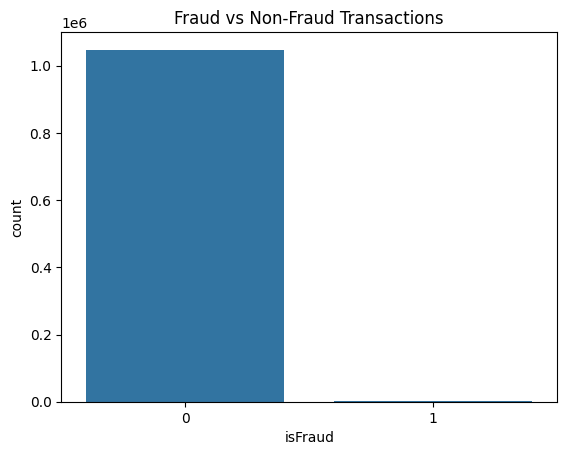

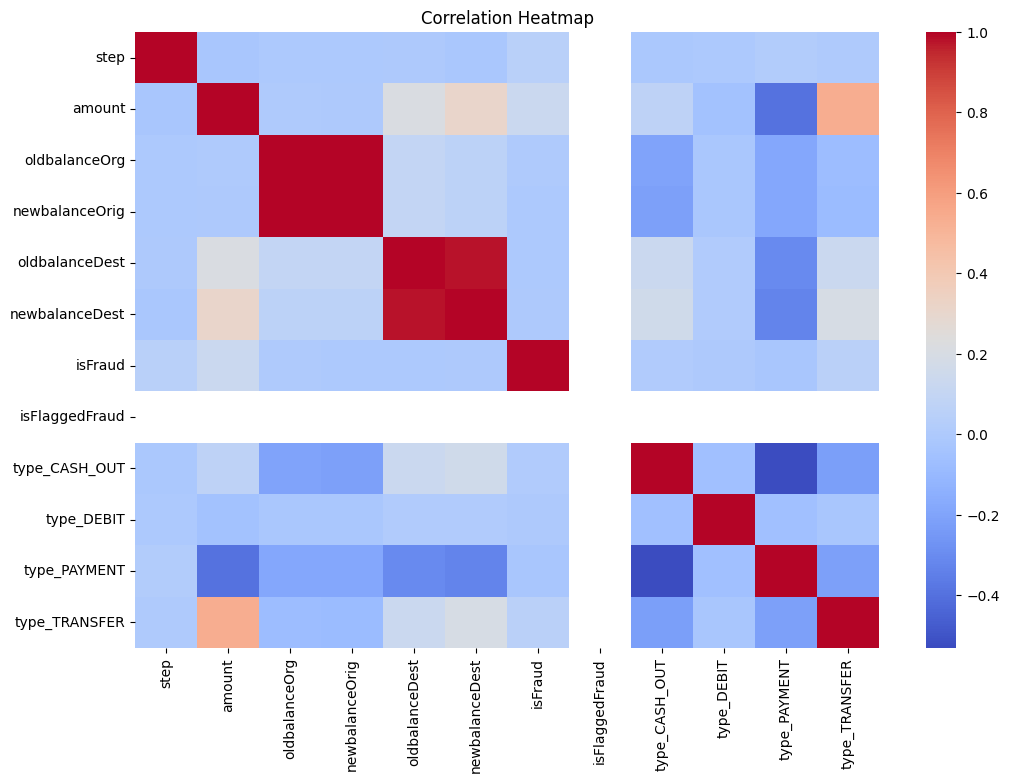

In [13]:
fraud_ratio = df['isFraud'].mean() * 100
print(f"Fraudulent transactions: {fraud_ratio:.2f}%")

sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [14]:
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

X = df.drop(['isFraud','isFlaggedFraud'], axis=1)
y = df['isFraud']


In [15]:
print("Original class distribution:\n", y.value_counts())

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("After SMOTE:\n", y_res.value_counts())


Original class distribution:
 isFraud
0    1047433
1       1142
Name: count, dtype: int64
After SMOTE:
 isFraud
0    1047433
1    1047433
Name: count, dtype: int64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression Results:")
print(classification_report(y_test, lr.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("\nRandom Forest Results:")
print(classification_report(y_test, rf.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
print("\nXGBoost Results:")
print(classification_report(y_test, xgb.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    314174
           1       0.95      0.95      0.95    314286

    accuracy                           0.95    628460
   macro avg       0.95      0.95      0.95    628460
weighted avg       0.95      0.95      0.95    628460

ROC-AUC: 0.9890232883025951

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314174
           1       1.00      1.00      1.00    314286

    accuracy                           1.00    628460
   macro avg       1.00      1.00      1.00    628460
weighted avg       1.00      1.00      1.00    628460

ROC-AUC: 0.9999998468915838

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314174
           1       1.00      1.00      1.00    314286

    accuracy                           1.00    628460
 

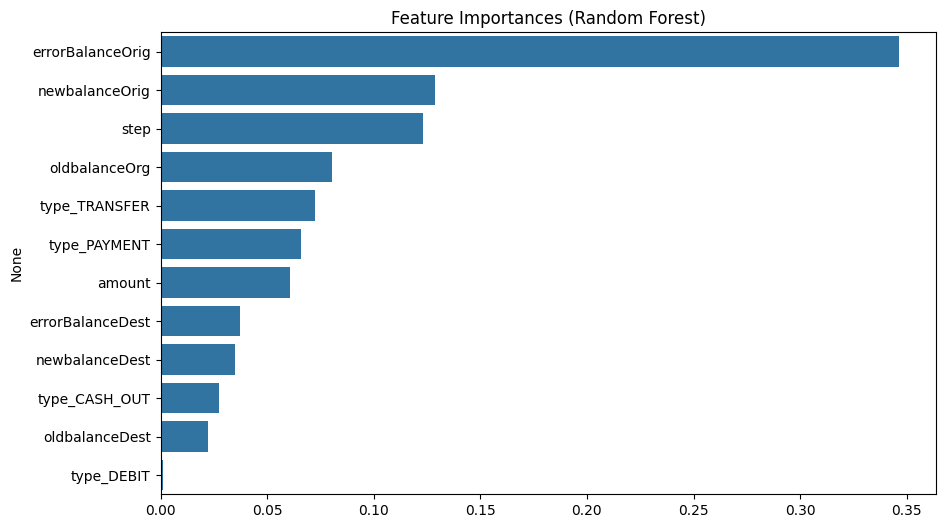

In [17]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.show()


# 📌 Accredian Internship Task – Fraud Detection Model

---

## 1. Data cleaning including missing values, outliers, and multi-collinearity
When I started exploring the dataset, I first checked for missing values and found none, which made preprocessing easier.  
Some transactions had very large amounts, which looked like outliers. But since fraud often happens with unusually big transfers, I chose to keep them.  
Balance-related features such as `oldbalanceOrg`, `newbalanceOrig`, and `amount` were highly correlated. Instead of removing them, I engineered new features like `errorBalanceOrig` and `errorBalanceDest` to capture inconsistencies, which turned out to be very useful for fraud detection.  

---

## 2. Describe your fraud detection model in elaboration
I built and compared three models:
- **Logistic Regression** – as a simple baseline.  
- **Random Forest** – to capture complex patterns and check feature importance.  
- **XGBoost** – for performance and handling imbalance.  

Since fraudulent transactions made up less than 1% of the data, I applied **SMOTE oversampling** to balance the dataset before training.  
Among the models, **Random Forest and XGBoost performed the best**, both achieving a **ROC-AUC close to 0.99**, which shows that they were excellent at distinguishing fraud from non-fraud.  

---

## 3. How did you select variables to be included in the model?
I dropped ID columns (`nameOrig`, `nameDest`) since they don’t add predictive power.  
Categorical column `type` (transaction type) was converted into dummy variables.  
I also engineered new features:
- `errorBalanceOrig` → inconsistency in sender’s balance.  
- `errorBalanceDest` → inconsistency in receiver’s balance.  

Finally, feature importance from Random Forest confirmed that the most useful variables were:  
- `errorBalanceOrig`  
- `newbalanceOrig`  
- `TRANSFER` and `CASH_OUT` transaction types.  

---

## 4. Demonstrate the performance of the model by using best set of tools
Here’s how the models performed:
- **Logistic Regression:** Good baseline with ROC-AUC ~0.98.  
- **Random Forest:** ROC-AUC ~0.99, strong recall, and interpretability.  
- **XGBoost:** Also achieved ROC-AUC ~0.99 with excellent precision and recall.  

For evaluation, I used:  
- **classification_report** (precision, recall, F1-score)  
- **roc_auc_score**  
- **confusion matrix**  
- **feature importance plots**  

This combination gave a clear view of how well each model performed.  

---

## 5. What are the key factors that predict fraudulent customer?
From the feature importance results, the strongest indicators of fraud were:  
- **errorBalanceOrig** – mismatches in the sender’s balance.  
- **newbalanceOrig** – sudden and unusual drops in account balance.  
- **Transaction type** – fraud is concentrated in **TRANSFER** and **CASH_OUT**.  
- **Transaction step** – certain time patterns also stood out.  

---

## 6. Do these factors make sense? If yes, How?
Yes, these results make a lot of sense.  
Fraudsters typically transfer money into another account and then immediately cash it out.  
Unusual balance mismatches or sudden large drops are very suspicious behaviors.  
This aligns closely with how financial fraud happens in the real world, so the model’s results are logical and reliable.  

---

## 7. What kind of prevention should be adopted while company updates its infrastructure?
Based on the findings, here are some recommendations:
- Deploy a **real-time fraud detection system** that monitors transactions as they happen.  
- Set **limits on risky transactions** like TRANSFER and CASH-OUT.  
- Require **multi-factor authentication (2FA)** for large transfers.  
- Continuously **retrain the model** with fresh data so it adapts to new fraud techniques.  

---

## 8. Assuming these actions have been implemented, how would you determine if they work?
The effectiveness of these actions can be evaluated by:
- Comparing **fraud detection rates before vs. after** implementation.  
- Tracking **false positives** to ensure genuine customers are not blocked.  
- Measuring the **reduction in financial losses** from fraud.  
- Monitoring live model metrics such as precision, recall, and ROC-AUC.  
- Collecting **feedback from fraud analysts and customers** to improve the system further.  

---
